# Planètes et Galaxie

**/!\ J'ai modifié plusieurs fichiers *.py* afin de faciliter le traitement réalisé ici. /!\\**

Principalement :

* *SolarSystem* et *Galaxy* intègrent maintenant le choix du schéma d'intégration en paramètre ;
* *SolarSystem* et *Galaxy* intègrent également le choix de $\theta$ (paramètres de l'algorithme de Barnes Hut) en paramètre.

Ces modifications ont des répercutions sur les autre fichiers *.py*, en particulier : tous les schémas d'intégration, ainsi que *energy.py* et *numba_functions.py* du module *Barnes Hut*.

J'ai également ajouté dans le répertoire racine du projet, un fichier *utils.py* qui permet de calculer l'energie d'un système simulé ici (avec les hypothèses associées).

# TODO :
* Pour *Galaxie*, il me semble que les masses sont initialisées avec un certain degré d'aléatoire. Je dois donc les stocker pour chaque simulation.

In [1]:
from examples.solar import SolarSystem
from examples.galaxy import Galaxy
import importlib
import numpy as np
import pygalaxy
from docopt import docopt
from pygalaxy.barnes_hut_array import compute_energy

In [2]:
from time import time

# importing function to compute the energy
from utils_energy import get_energy_solar, get_energy_planet # get_center_of_mass
from utils_plotting import Plot

# Premier test avec tous les schémas

## Choix des paramètres et du système à intégrer

In [17]:
# last 3 are symplectics
schemes = ['Euler_symplectic','Euler', 'Euler', 'Euler'] # ['RK4', 'ADB6', 'Euler_symplectic','Stormer_verlet','Optimized_815']

system = 'SolarSystem' # 'Galaxy', 'SolarSystem'

if(system == 'Galaxy'):
    # TODO : make initialization of the galaxy and solar system the same. Here the init of the solar system is automatically done inside,
    # whereas in the case of the galaxy it's done outside (via blackhole here)
    # solar system -> blackhole 
    # (makes sense how it was done, since the solar system remains the same anyway)
    blackHole = [
            {
                'coord': [0, 0],
                'mass': 1000000,
                'svel': 1,
                'stars': 200,
                'radstars': 3
            },

            {
                'coord': [3, 3],
                'mass': 1000000,
                'svel': 0.9,
                'stars': 100,
                'radstars': 1
            }]
    # args en plus 
    args = {
        'theta' : 0.0
    }
    # simu parameters
    dt_in_days = 0.1
    number_of_steps = 10
    
    names = None

else:
    # args en plus 
    args = {
        'theta' : 0.0
    }
    # simu parameters
    dt_in_days = [0.1,0.1,1,10]
    number_of_steps = [1000,1000,100,10]
    
    names = ['sun', 'mercury', 'venus', 'earth', 'mars', 'jupiter', 'saturn', 'uranus', 'neptune']


## Plot des trajectoires des planètes

In [18]:


saving_lists = []
masses = []

for i, scheme in enumerate(schemes):
    dt_in_days_ = dt_in_days[i] if type(dt_in_days) == list else dt_in_days
    number_of_steps_ = number_of_steps[i] if type(number_of_steps) == list else number_of_steps
    args_ = args[i] if type(args)==list else args
    
    print('Simulation with dt = {} days and for {} steps. Total : {} days.'.format(dt_in_days_,number_of_steps_, dt_in_days_*number_of_steps_))

    if(system=='Galaxy'):
        sim = Galaxy(blackHole, dt = dt_in_days_*pygalaxy.physics.day_in_sec, display_step=number_of_steps_,
                    scheme = scheme, args_method = args_)
    else: 
        sim = SolarSystem(dt = dt_in_days_*pygalaxy.physics.day_in_sec, display_step=number_of_steps_,
                      scheme = scheme, args_method = args_)
        
    # compute initial energy
    init_energy = get_energy_solar(sim.particles, sim.mass, verbose = False)
    
    t1=time()
    saving_lists.append(sim.next(return_pos = True)) # in theory, it already computes energy inside next() (inside the scheme used in fact)
    masses.append(sim.mass)
    t2=time()
    
    # final energy
    final_energy = get_energy_solar(sim.particles, sim.mass, verbose = False)
    
    print('{} : {} secs. Fractional change in Energy: {:.5} %'.format(scheme, "{:e}".format(t2-t1),"{}".format(100*(final_energy-init_energy)/init_energy)))
    print('Initial energy being : {:.3} J.\n'.format(init_energy))

Simulation with dt = 0.1 days and for 1000 steps. Total : 100.0 days.
Euler_symplectic : 1.696248e-01 secs. Fractional change in Energy: 0.230 %
Initial energy being : 9.16e+40 J.

Simulation with dt = 0.1 days and for 1000 steps. Total : 100.0 days.
Euler : 8.361149e-02 secs. Fractional change in Energy: 0.230 %
Initial energy being : 9.16e+40 J.

Simulation with dt = 1 days and for 100 steps. Total : 100 days.
Euler : 8.695364e-03 secs. Fractional change in Energy: 0.226 %
Initial energy being : 9.16e+40 J.

Simulation with dt = 10 days and for 10 steps. Total : 100 days.
Euler : 1.324892e-03 secs. Fractional change in Energy: 0.167 %
Initial energy being : 9.16e+40 J.



# Plotting

In [19]:
plotter = Plot(saving_lists, masses, schemes, dt_in_days, names = names)
plotter

Plotter :
	Schemes : ['Euler_symplectic', 'Euler', 'Euler', 'Euler']
	Number of simulations : 4 
	Number of bodies : 9 
	Number of time steps : [1000 1000  100   10] 
	Time step : [ 0.1  0.1  1.  10. ] day
	Body names : ['sun', 'mercury', 'venus', 'earth', 'mars', 'jupiter', 'saturn', 'uranus', 'neptune']

Schéma : Euler_symplectic


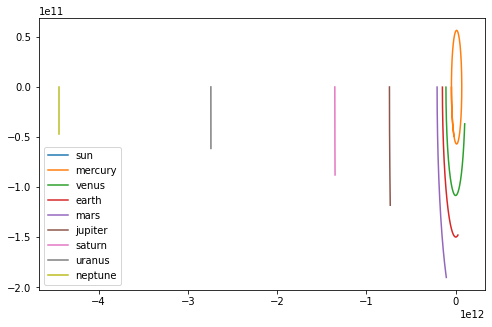

Schéma : Euler


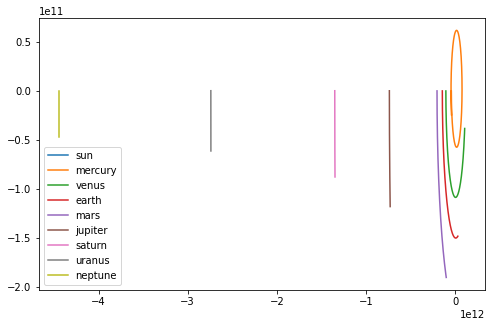

Schéma : Euler


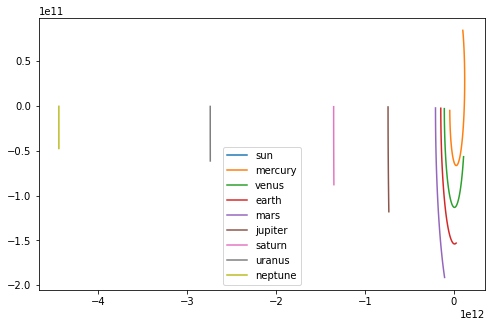

Schéma : Euler


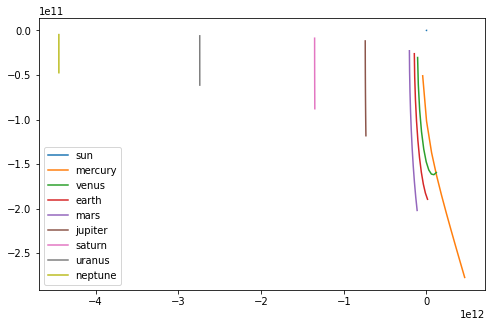

In [20]:
plotter.plot_positions()

Euler_symplectic ; dt = 0.1 days


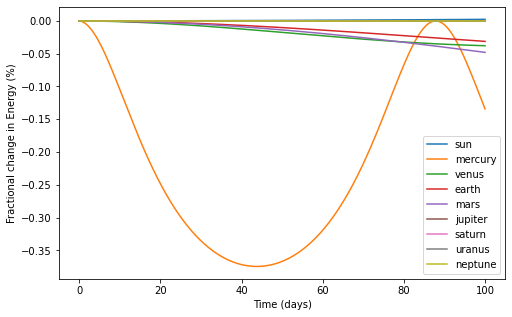

Euler ; dt = 0.1 days


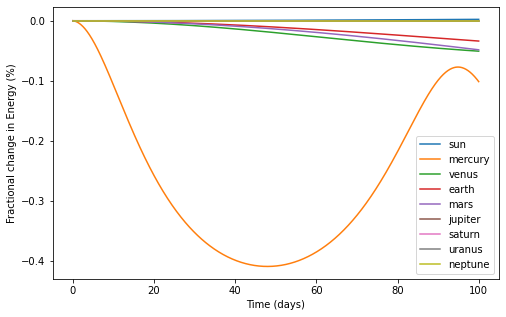

Euler ; dt = 1.0 days


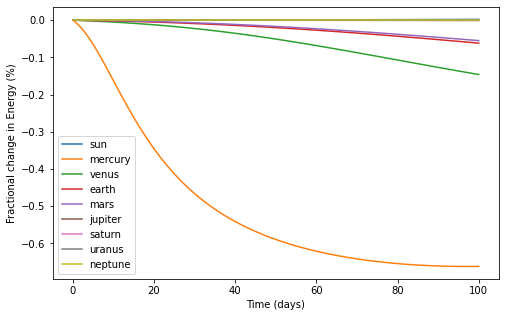

Euler ; dt = 10.0 days


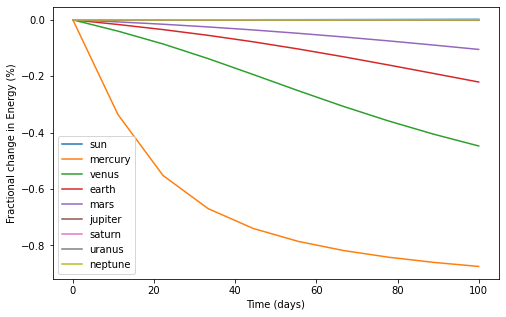

In [21]:
plotter.plot_energy(per_scheme = True)

sun : 


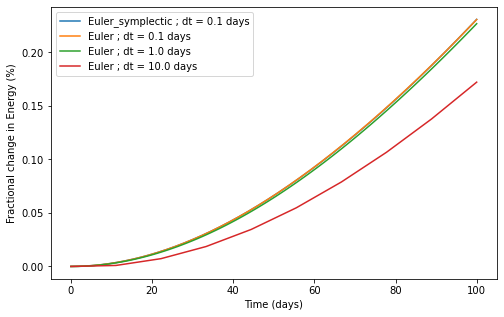

mercury : 


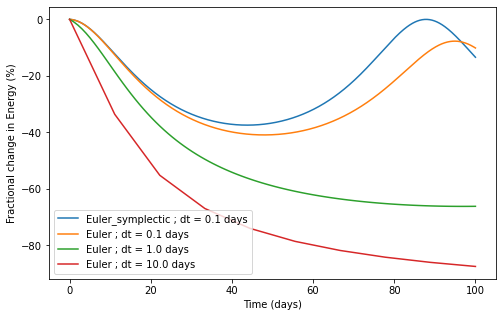

venus : 


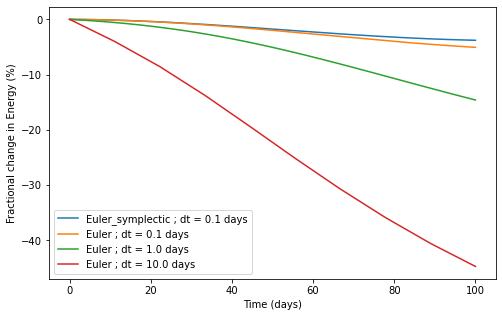

earth : 


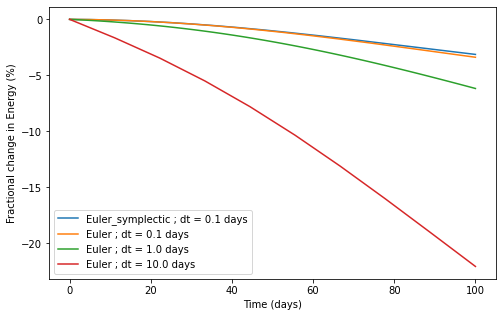

mars : 


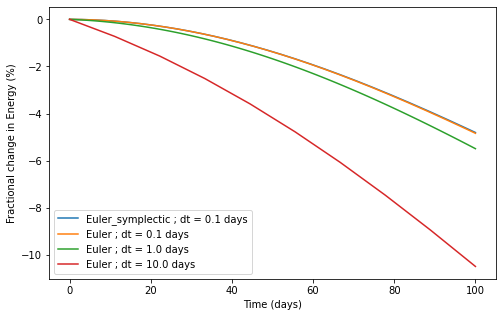

jupiter : 


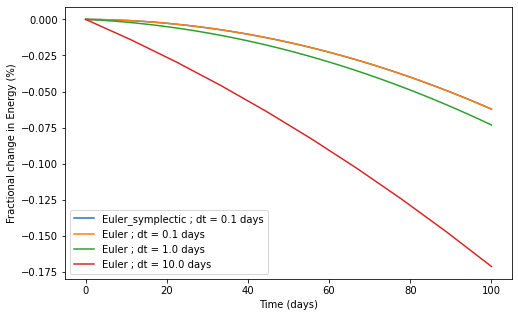

saturn : 


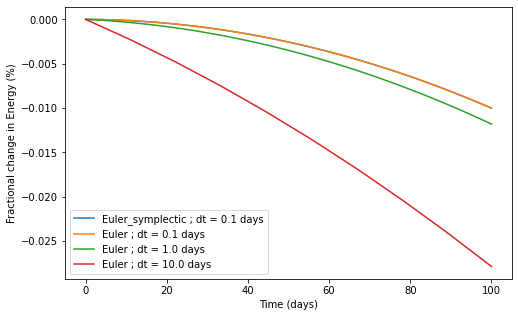

uranus : 


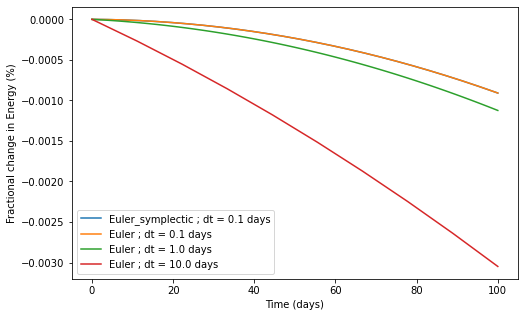

neptune : 


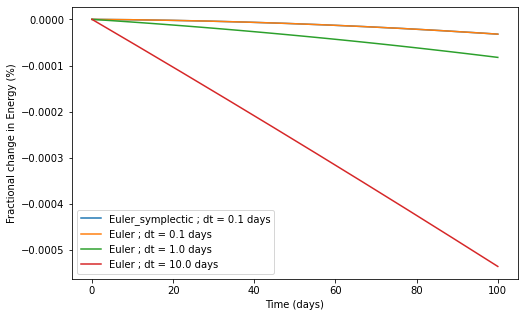

In [22]:
 plotter.plot_energy(per_body = True)

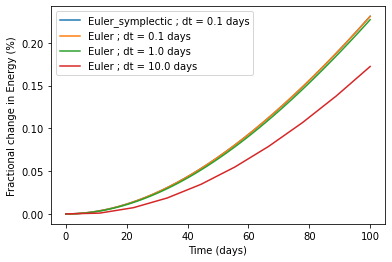

In [23]:
plotter.plot_energy(sum_energy = True)